Imports

In [1]:
from jitcdde import jitcdde, y, t
from parameters import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Define System

In [2]:

# delays
taus = [tau_c, tau_c_hx, tau_hx_c, tau_hx_r, tau_l, tau_r_hx]

# dT/dt for radiator nodes
T_out_rc = (W_rp/mn_rp)*(y(11,t-tau_hx_r)-y(0)) + (hA_rpn/mcp_rpn)*(y(1)-y(0))                  # T_out_rc: y(0)
T_out_air = -((W_rs/mn_rs)+(hA_rsn/mcp_rsn))*y(1) + (hA_rsn/mcp_rsn)*y(0) + (W_rs/mn_rs)*Trs_in # T_out_air: y(1)

# dT/dt for heat exchanger nodes
T_hf1 = -((W_p/mn_p)+(hA_pn/mcp_pn))*y(2) + (hA_pn/mcp_pn)*y(6) + (W_p/mn_p)*y(21,t-tau_c_hx)  # T_hf1: y(2)
T_hf2 = (W_p/mn_p)*(y(2)-y(3)) + (hA_pn/mcp_pn)*(y(6)-y(2))                                    # T_hf2: y(3)
T_hf3 = -((W_p/mn_p)+(hA_pn/mcp_pn))*y(4) + (hA_pn/mcp_pn)*y(7) + (W_p/mn_p)*y(3)              # T_hf3: y(4)
T_hf4 = (W_p/mn_p)*(y(4)-y(5)) + (hA_pn/mcp_pn)*(y(7)-y(4))                                    # T_hf4: y(5)
T_ht1 = (2*hA_pn/mcp_tn)*(y(2)-y(6)) + (2*hA_sn/mcp_tn)*(y(10)-y(6))                           # T_ht1: y(6)
T_ht2 = (2*hA_pn/mcp_tn)*(y(4)-y(7)) + (2*hA_sn/mcp_tn)*(y(8)-y(7))                            # T_ht2: y(7)
T_hc1 = -((W_s/mn_s)+(hA_sn/mcp_sn))*y(8) + (hA_sn/mcp_sn)*y(7) + (W_s/mn_s)*y(0,t-tau_r_hx)   # T_hc1: y(8)
T_hc2 = (W_s/mn_s)*(y(8)-y(9)) + (hA_sn/mcp_sn)*(y(7)-y(8))                                    # T_hc2: y(9)
T_hc3 = -((W_s/mn_s)+(hA_sn/mcp_sn))*y(10) + (hA_sn/mcp_sn)*y(6) + (W_s/mn_s)*y(9)             # T_hc3: y(10)
T_hc4 = (W_s/mn_s)*(y(10)-y(11)) + (hA_sn/mcp_sn)*(y(6)-y(10))                                 # T_hc4: y(11)

# dn/dt
n = (y(22)-beta_t)*y(12)/Lam+lam[0]*y(13)+lam[1]*y(14)+lam[2]*y(15)+lam[3]*y(16)+lam[4]*y(17)+lam[5]*y(18) # n (no source insertion): y(12)

# dC_i/dt (precursor concentrations)
C1 = y(12)*beta[0]/Lam-lam[0]*y(13)-y(13)/tau_c+y(13,t-tau_l)*np.exp(-lam[0]*tau_l)/tau_c  # C1: y(13)
C2 = y(12)*beta[1]/Lam-lam[1]*y(14)-y(14)/tau_c+y(14,t-tau_l)*np.exp(-lam[1]*tau_l)/tau_c  # C2: y(14)
C3 = y(12)*beta[2]/Lam-lam[2]*y(15)-y(15)/tau_c+y(15,t-tau_l)*np.exp(-lam[2]*tau_l)/tau_c  # C3: y(15)
C4 = y(12)*beta[3]/Lam-lam[3]*y(16)-y(16)/tau_c+y(16,t-tau_l)*np.exp(-lam[3]*tau_l)/tau_c  # C4: y(16)
C5 = y(12)*beta[4]/Lam-lam[4]*y(17)-y(17)/tau_c+y(17,t-tau_l)*np.exp(-lam[4]*tau_l)/tau_c  # C5: y(17)
C6 = y(12)*beta[5]/Lam-lam[5]*y(18)-y(18)/tau_c+y(18,t-tau_l)*np.exp(-lam[5]*tau_l)/tau_c  # C6: y(18)

# dT/dt core nodes
T_cg = (hA_fg/mcp_g1)*(y(20)-y(19)) + k_g*P*y(12)/mcp_g1                                             # T_cg: y(19)
T_cf1 = W_f/mn_f*(y(5,t-tau_hx_c)-y(20)) + (k_f1*P*y(12)/mcp_f1) + (hA_fg*k_1*(y(19)-y(20))/mcp_f1)  # T_cf1: y(20)
T_cf2 = W_f/mn_f*(y(20)-y(21)) + (k_f2*P*y(12)/mcp_f2) + (hA_fg*k_2*(y(19)-y(20))/mcp_f2)            # T_cf2: y(21)

# rho y(22)
rho = (a_f/2)*(T_cf1 + T_cf2) + (a_g)*(T_cg)

# instantiate jitcdde object
DDE = jitcdde([T_out_rc,T_out_air,T_hf1,T_hf2,T_hf3,T_hf4,T_ht1,T_ht2,T_hc1,
               T_hc2,T_hc3,T_hc4,n,C1,C2,C3,C4,C5,C6,T_cg,T_cf1,T_cf2,rho])

initial_condition = [T0_rp, T0_rs, T0_p1,T0_p2, T0_p3, T0_p4, T0_t1, T0_t2, T0_s1, T0_s2, 
          T0_s3, T0_s4, n_frac0, C0[0], C0[1], C0[2], C0[3], C0[4], C0[5], 
          T0_g1, T0_f1, T0_f2,0.0]

# set initial conditions
DDE.constant_past([T0_rp, T0_rs, T0_p1,T0_p2, T0_p3, T0_p4, T0_t1, T0_t2, T0_s1, T0_s2, 
          T0_s3, T0_s4, n_frac0, C0[0], C0[1], C0[2], C0[3], C0[4], C0[5], 
          T0_g1, T0_f1, T0_f2,0.0])



In [3]:
-((W_p/mn_p)+(hA_pn/mcp_pn))*initial_condition[2] + (hA_pn/mcp_pn)*initial_condition[6] + (W_p/mn_p)*initial_condition[21] 

-12.575702421378764

In [14]:
T0_f2

657.27

Unpack data

In [4]:
# simulink data
df_simulink = pd.read_excel("./data/k_500_simulink.xlsx")

Solve

In [5]:

# jitcdde solve
data_solver = []
for t_x in df_simulink['time']:
    data_solver.append(DDE.integrate(t_x))

n_jit = [d[12] for d in data_solver]

Generating, compiling, and loading C code.
Using default integration parameters.


/home/luke/git/envs/thesis_env/lib/python3.11/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.
  warn("You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.")
/home/luke/git/envs/thesis_env/lib/python3.11/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did no

Plot solution

(0.0, 100.0)

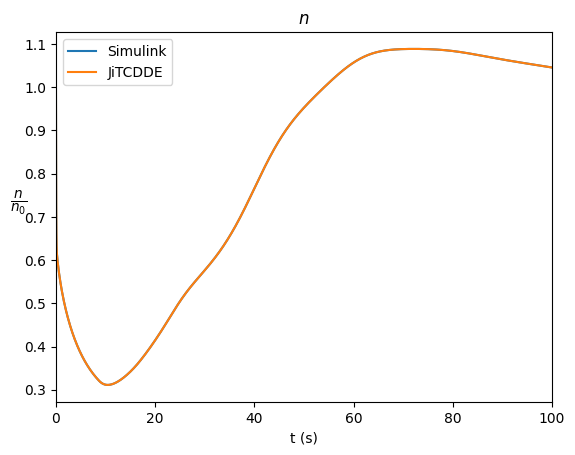

In [6]:
plt.plot(df_simulink['time'],df_simulink['Mux(4)'],label="Simulink")
plt.plot(df_simulink['time'],n_jit,label="JiTCDDE")
plt.title(r'$n$')
plt.legend()
plt.xlabel('t (s)')
plt.ylabel(r'$\frac{n}{n_0}$',rotation=0,fontsize=14)
plt.savefig('n')
plt.xlim([0,100])


Plot manual solver vs JitCDDE

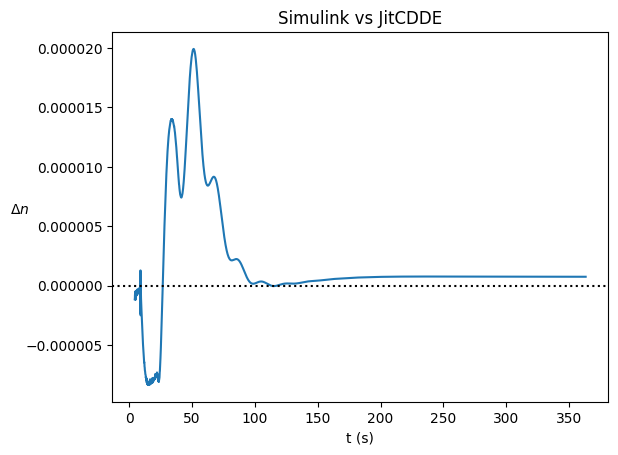

In [7]:
start_index = 50
stop_index = 4000
plt.plot(df_simulink['time'][start_index:stop_index],np.subtract(df_simulink['Mux(4)'],n_jit)[start_index:stop_index],label="Simulink")
plt.title("Simulink vs JitCDDE")
plt.ylabel(r"$\Delta n$",rotation=0)
plt.xlabel("t (s)")
plt.ticklabel_format(axis='y', style='sci', scilimits=(-6,-4))
plt.axhline(0, color='black', linestyle='dotted')

In [19]:
outlet = [s[21] for s in data_solver]
inlet = [s[20] for s in data_solver]
(outlet[-1]-inlet[-1])*W_f*scp_f

3.9477087361453056

In [20]:
P*data_solver[-1][12]/2

3.9452425130865376